<a href="https://colab.research.google.com/github/JeanleeRoy/CS3I01-seguridad-labs/blob/master/lab5a/lab5a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5a: HashCash  
En este lab, vamos a hablar sobre una aplicación de Hashing que se puede usar para combatir el spam. De hecho, no sólo es útil para spam. La función que vamos a ver, llamada HashCash, sirve como base para el algoritmo de consenso que se utiliza en BitCoin, un método que comúnmente se denomina como Proof-of-Work, ya que requiere cierta cantidad de "trabajo" promedio para calcular. Vamos a implementar esta función y analizar un poco el trabajo que se requiere para calcularla.  
  
Para empezar, lee las primeras 3 secciones de este documento: http://www.hashcash.org/papers/hashcash.pdf  
  
En el documento mencionan que el string a calcular normalmente se agrega a un string basado en el servicio que se está usando. También se le agregan otros detalles, como la versión de la función, el número de bits a chequear, un timestamp, y algún denominador del servicio/usuario. Debajo hay algunos ejemplos de cómo se ve un formato de string de HashCash en la vida real. Vamos a usar SHA-1 como el Hash.  
  
Ejemplo de formato de HashCash:

In [ ]:
!pip install cryptography

In [2]:
from cryptography.hazmat.primitives import hashes
import matplotlib.pyplot as plt
import time
import random
import math

def hash(msg: str):
	digest = hashes.Hash(hashes.SHA1())
	digest.update(msg.encode("unicode_escape"))
	return digest.finalize().hex()

example = "1:20:1303030600:jpazos@utec.edu.pe::McMybZIhxKXu57jd:ckvi"

hash(example)

'0ec57d01555bb613eeb6a3c20a0fcc64ef581794'

## Ejemplo de verificación correcta de hash. Se tienen 24 0-bits según el string, y el hash tiene 6 0s en hex.

In [3]:
hash("1:24:040806:foo::511801694b4cd6b0:1e7297a")

'0000008e3caaff34c595a55f7cc53c6b1cd385d1'

# Ejercicio: implementa la versión recursiva de HashCash.  
Puedes verificar que funciona calculando el hash y verificando que tiene la cantidad
de bits deseada. Nota que estamos trabajando con Hex por ahora, entonces pueden haber más bits de 0 de los necesarios, pero con tal que
hayan por lo menos 8 (o los que especifiques) sería correcto.

In [4]:
def recursiveHashCash(ver: int, bits: int, resource: str, iv: str, ctr: int):
	curTime = str(int(time.time()) + int(random.random()*10**7))
	baseStr = makeBaseStr(ver, bits, curTime, resource, iv, ctr)
	hashed = hash(baseStr)

	if checkBits(hashed, bits):
		return hashed
	else:
		return recursiveHashCash(ver, bits, resource, iv, ctr)

def makeBaseStr(*args):
	return ':'.join([str(s) for s in args])

def checkBits(hashed: str, bits: int):
	bitCheck = bits//4
	return hashed[:bitCheck] == "0"*bitCheck


In [5]:
version = 1
bits = 8
resource = "UTECSecurity"

res = recursiveHashCash(version,bits,resource,str(random.randint(1e17,1e18)),0)
print(res)
print(hash(res))

0046cec76694df0f938d593f399f7334559f5eae
020116a0b6a2dcd250966deb14f896d855268bcc


## Ejercicio: Trata aumentando la cantidad de bits, ¿qué pasa? Lamentablemente python nos empieza a fallar. ¿Qué pasa si tratas de agregar tail recursion?

In [6]:
# tail_recursion: code taken from https://chrispenner.ca/posts/python-tail-recursion
class Recurse(Exception):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs

def recurse(*args, **kwargs):
    raise Recurse(*args, **kwargs)
        
def tail_recursive(f):
    def decorated(*args, **kwargs):
        while True:
            try:
                return f(*args, **kwargs)
            except Recurse as r:
                args = r.args
                kwargs = r.kwargs
                continue
    return decorated

In [12]:
# Apply tail recursion
@tail_recursive
def tailRecursiveHashCash(ver: int, bits: int, resource: str, iv: str, ctr: int):
    curTime = str(int(time.time()) + int(random.random()*10**7))
    baseStr = str(ver) + ':' + str(bits) + ':' + curTime + ':' + resource + ':' + iv + ':' + str(ctr)
    hashed = hash(baseStr)

    if checkBits(hashed, bits):
        return hashed
    recurse(ver, bits, resource, iv, ctr)

In [13]:
version = 1
bits = 8
resource = "UTECSecurity"

res = tailRecursiveHashCash(version,bits,resource,str(random.randint(1e17,1e18)),0)
print(res)
print(hash(res))

0015b97983c532d934ce3f900dc70ea3df658d3f
471097770cea6c8761ec687e2fc67eb409989d29


## Ejercicio: Para librarnos del problema anterior, podemos usar iteration. Implementa una versión iterativa de HashCash.

In [15]:
def iterativeHashCash(ver: int, bits: int, resource: str, iv: str, ctr: int):
	#assert(bits >= 4), "bits provided can't be lower than 4"
	while True:
		curTime = int(time.time()) + int(random.random()*10**8)
		baseStr = makeBaseStr(ver, bits, curTime, resource, iv, ctr)
		hashed = hash(baseStr)
		if checkBits(hashed, bits):
			return hashed

version = 1
bits = 16
resource = "UTECSecurity"

res = iterativeHashCash(version,bits,resource,random.randint(1e17,1e18),0)
print(res)
print(hash(res))

00009cb0752acebc1d0970b7356e988bea05cbc9
19625e0aa27c0768ad7436f817174f50f2c50aa2


## Ejercicio: Ahora que podemos correr la función con más bits, probemos el performance conforme incrementemos los bits. 

In [16]:
resource = "UTECSecurity"
for i in range(4,28,4):
	print("="*10,"\n",i,"bits:")
	%time iterativeHashCash(1,i,resource,random.randint(1e17,1e18),0)

 4 bits:
CPU times: user 1.47 ms, sys: 6 µs, total: 1.48 ms
Wall time: 1.49 ms
 8 bits:
CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.78 ms
 12 bits:
CPU times: user 423 ms, sys: 2.98 ms, total: 426 ms
Wall time: 429 ms
 16 bits:
CPU times: user 335 ms, sys: 986 µs, total: 336 ms
Wall time: 341 ms
 20 bits:
CPU times: user 28.4 s, sys: 68.3 ms, total: 28.4 s
Wall time: 28.4 s
 24 bits:
CPU times: user 7min 4s, sys: 1 s, total: 7min 5s
Wall time: 7min 5s


Lamentablemente, trabajar con hex nos limita bastante, ya que solo podemos incrementar la cantidad de bits de a 4.  
Queremos poder incrementar de a 1 para poder calcular mejor el cambio en tiempos mientras incrementamos los bits.  
  
# Ejercicio: Implementar de iterativeHashCashPartial y CheckBitsPartial, que permite analizar el ByteArray, de modo que podamos incrementar bit por bit la dificultad de HashCash.

In [17]:
def hextobin(h):
  return bin(int(h, 16))[2:].zfill(len(h) * 4)

def getRTime():
	return int(time.time())+int(random.random()*10**8)

def iterativeHashCashPartial(ver: int, bits: int, resource: str, iv: str, ctr: int):
	while True:
		baseStr = makeBaseStr(ver, bits, getRTime(), resource, iv, ctr)
		hashed = hash(baseStr)
		if checkBitsPartial(hashed, bits):
			return hashed

def checkBitsPartial(hashed: str, bits: int):
	bHashed = hextobin(hashed)
	return bHashed[:bits] == "0"*bits

res = iterativeHashCashPartial(1,6,resource,str(random.randint(1e17,1e18)),0)
print(res)
print(hash(res))
print(hextobin(res))
print(hextobin(hash(res)))

004b2419240a51d52c9ef0063f4104688ac78832
1425d8f23586ac4be994cc0254c2d036e7ec55ab
0000000001001011001001000001100100100100000010100101000111010101001011001001111011110000000001100011111101000001000001000110100010001010110001111000100000110010
0001010000100101110110001111001000110101100001101010110001001011111010011001010011001100000000100101010011000010110100000011011011100111111011000101010110101011


# Calcular tiempo para diferentes 0-bit-strings.

In [18]:
resource = "UTECSecurity"
max_bits = 20
for i in range(max_bits):
	print("="*10,"\n",i,"bits:")
	%time iterativeHashCashPartial(version,i,resource,random.randint(1e17,1e18),0)

 0 bits:
CPU times: user 226 µs, sys: 1e+03 ns, total: 227 µs
Wall time: 234 µs
 1 bits:
CPU times: user 259 µs, sys: 0 ns, total: 259 µs
Wall time: 265 µs
 2 bits:
CPU times: user 180 µs, sys: 0 ns, total: 180 µs
Wall time: 184 µs
 3 bits:
CPU times: user 179 µs, sys: 0 ns, total: 179 µs
Wall time: 183 µs
 4 bits:
CPU times: user 344 µs, sys: 0 ns, total: 344 µs
Wall time: 348 µs
 5 bits:
CPU times: user 3.74 ms, sys: 3 µs, total: 3.74 ms
Wall time: 3.55 ms
 6 bits:
CPU times: user 2.13 ms, sys: 0 ns, total: 2.13 ms
Wall time: 1.67 ms
 7 bits:
CPU times: user 5.13 ms, sys: 0 ns, total: 5.13 ms
Wall time: 4.64 ms
 8 bits:
CPU times: user 9.82 ms, sys: 0 ns, total: 9.82 ms
Wall time: 9.27 ms
 9 bits:
CPU times: user 3.88 ms, sys: 4 µs, total: 3.88 ms
Wall time: 3.05 ms
 10 bits:
CPU times: user 7.8 ms, sys: 4 µs, total: 7.8 ms
Wall time: 7.12 ms
 11 bits:
CPU times: user 49 ms, sys: 4 µs, total: 49 ms
Wall time: 48.3 ms
 12 bits:
CPU times: user 13.4 ms, sys: 2 µs, total: 13.4 ms
Wall t

# Ejercicio: Dibuja un gráfico de los tiempos con distintas cantidades de bits a chekear. ¿Se ve como esperarías? ¿Por qué hay diferencias?
Puedes usar librerias como matplotlib o seaborn

In [ ]:
def plotBars(x,y,y_label):
    plt.bar(x,y)
    plt.xlabel('n bits')
    plt.ylabel(y_label+"(us)")
    plt.title(f"Grafico bits vs {y_label}")
    plt.xticks(range(0,max_bits))
    plt.show()

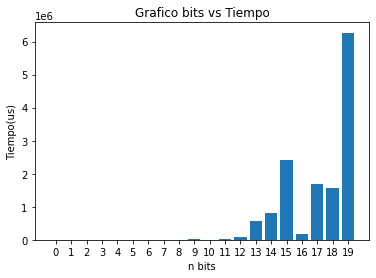

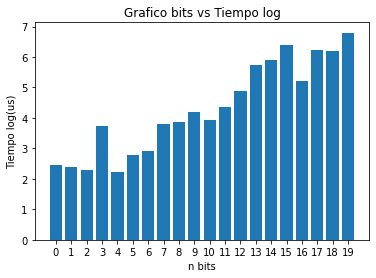

In [ ]:
x = []
y = []
ylog = []
for i in range(20):
    x.append(i)
    start = time.time()
    iterativeHashCashPartial(version,i,resource,random.randint(1e17,1e18),0)
    end = time.time()
    diff = (end-start)*1000_000
    y.append(diff)
    ylog.append(math.log(diff,10))

plotBars(x,y,"Tiempo")
print()
plotBars(x,ylog,"Tiempo log")

### Respuesta
Como se puede apreciar en la primera gráfica, la diferencia de tiempo que toma realizar el hashing con 1 solo cero inicial y 19 ceros es muy grande. Debido a esta gran diferencia el tiempo para pocos bits de ceros es casi imperceptible en comparación a los tiempos con una cantidad mayor a 12 bits.

Para poder visualizar mejor el tiempo según la cantidad de bits, en la segunda gráfica se puede apreciar el tiempo con una transformación logrítmica. Esta gráfica nos da una idea más clara de la tendencia que siguen los datos.

Esa tendencia ascendente es el comportamiento que se esperaba, sin embargo, se puede observar que en algunos casos dicha tendencia no se cumple. Eso se evidencia en el salto que hay de 15 bits a 16 bits. Una razón que puede explicar esto es que los hashes creados presentan una estructura casi aleatoria y son algo caóticos. Situación que puede llegar a influir grandemente al momento de validar los bits iniciales del hash.

Entonces, en teoría, mientras mayor sea la cantidad de bits iniciales de un hash con ceros esperados, mayor será el tiempo en poder crearlo. En la práctica, está creación puede no seguir esta tendencia descrita debido a la propia naturaleza caótica de los hashes.

# Ejercicio: Una de las aplicaciones que se tenía en mente originalmente para HashCash era combatir el Spam en email. Describe cómo se podría utilizar HashCash para ayudar con este problema.

# Bonus:  Bitcoin, una de las aplicaciones que hace uso de HashCash usa la función SHA-256 para hacer hashing. También se usan IVs y contadores más grandes (alrededor de 64 bytes cada uno) para evitar la probabilidad de reuso de un IV. Extiende la longitud de los IVs y el CTR en tus cálculos y compara las diferencia de tiempo. ¿Es significativa?

# Bonus: Ejercicio: Bitcoin mantiene una dificultad de hashing de modo que un bloque sea agregado al Blockchain mas o menos cada 10 minutos. Usando la extensión del problema anterior, y asumiendo una escala teórica del incremento del tiempo, ¿más o menos qué longitud debería tener el string de 0s para que demore 10 minutos encontrar una solución según tus tiempos?